In [1]:
import numpy as np
from mockfactory import Catalog
from pypower import utils
from cosmoprimo.fiducial import DESI
cosmo = DESI()

In [2]:
def get_positions_xyz(dat):
    dists=cosmo.comoving_radial_distance(dat['Z'])
    return np.asarray(utils.sky_to_cartesian(np.array([dat['RA'],dat['DEC'],dists])))
def get_min_boxsize(dat):
    positions_xyz= get_positions_xyz(data)
    return np.abs(np.max(positions_xyz,axis=1) - np.min(positions_xyz,axis=1))

In [3]:
tracers = ['QSO','LRG','ELG_LOPnotqso']
basedir = "/global/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/holi_v1/altmtl452/loa-v1/mock452/LSScats/"

zrange_dict    = {'ELG_LOPnotqso':[(0.8,1.1),(1.1,1.6)], 
                  'LRG':[(0.4,0.6),(0.6,0.8),(0.8,1.1)], 
                  'QSO':[(0.8,2.1)]}
regions = ['NGC','SGC']
test_boxsize_list = [1000*i for i in range(4,10+1)]
    
for tracer in tracers:
    print(f"For {tracer[:3]}")
    data_fn  = [basedir + f"{tracer}_{reg}_clustering.dat.h5" for reg in regions] 
    data_full = Catalog.read(data_fn[0],group='LSS')
    data_full.append(Catalog.read(data_fn[1],group='LSS'))
    for iz in zrange_dict[tracer]:
        zmin,zmax = iz
        mask = (data_full['Z'] >= zmin) & ( data_full['Z'] <= zmax)
        data = data_full[mask]
        
        #Get minimum boxsize
        # data_positions_xyz= get_positions_xyz(data)
        # randoms_positions_xyz = get_positions_xyz(rands)
        # positions_xyz = np.hstack([data_positions_xyz,randoms_positions_xyz])
        data_min_boxsize = get_min_boxsize(data)
        print(f'from data ({zmin} < z < {zmax}) boxsize must be greater than ',data_min_boxsize)
        # print('from randoms boxsize must be greater than ',np.abs(np.max(randoms_positions_xyz,axis=1) - np.min(randoms_positions_xyz,axis=1)))
        # print('boxsize must be greater than ',np.abs(np.max(positions_xyz,axis=1) - np.min(positions_xyz,axis=1)))
        
        for test_boxsize in test_boxsize_list:
            print(f"Given {test_boxsize} / {np.max(data_min_boxsize):.0f} = {test_boxsize/np.max(data_min_boxsize):.2f}")
    print()

For QSO
from data (0.8 < z < 2.1) boxsize must be greater than  [4374.72654592 6713.29041716 4235.95942828]
Given 4000 / 6713 = 0.60
Given 5000 / 6713 = 0.74
Given 6000 / 6713 = 0.89
Given 7000 / 6713 = 1.04
Given 8000 / 6713 = 1.19
Given 9000 / 6713 = 1.34
Given 10000 / 6713 = 1.49

For LRG
from data (0.4 < z < 0.6) boxsize must be greater than  [1822.52627584 2806.72758383 1766.83150347]
Given 4000 / 2807 = 1.43
Given 5000 / 2807 = 1.78
Given 6000 / 2807 = 2.14
Given 7000 / 2807 = 2.49
Given 8000 / 2807 = 2.85
Given 9000 / 2807 = 3.21
Given 10000 / 2807 = 3.56
from data (0.6 < z < 0.8) boxsize must be greater than  [2311.9490271  3543.05925091 2225.82556726]
Given 4000 / 3543 = 1.13
Given 5000 / 3543 = 1.41
Given 6000 / 3543 = 1.69
Given 7000 / 3543 = 1.98
Given 8000 / 3543 = 2.26
Given 9000 / 3543 = 2.54
Given 10000 / 3543 = 2.82
from data (0.8 < z < 1.1) boxsize must be greater than  [2916.7750721  4489.14760778 2819.68033484]
Given 4000 / 4489 = 0.89
Given 5000 / 4489 = 1.11
Given

In [5]:
import numpy as np
from matplotlib import pyplot as plt

import lsstypes as types
from lsstypes import read, mean, cov
from tools import get_power_fn
from tqdm import tqdm

In [6]:
nran = 10
cellsize_dict  = {'ELG_LOPnotqso':7.8, 'LRG':7.8, 'QSO':7.8}
boxsize_list_dict = {'ELG_LOPnotqso':[6000,7000,8000,9000,10000], 
                     'LRG':[5000,6000,7000,8000,9000,10000],
                     'QSO':[7000,8000,9000,10000]}
zrange_dict       = {'ELG_LOPnotqso':[(0.8,1.1),(1.1,1.6)], 
                     'LRG':[(0.4,0.6),(0.6,0.8),(0.8,1.1)], 
                     'QSO':[(0.8,2.1)]}

  0%|          | 0/1 [00:00<?, ?it/s]

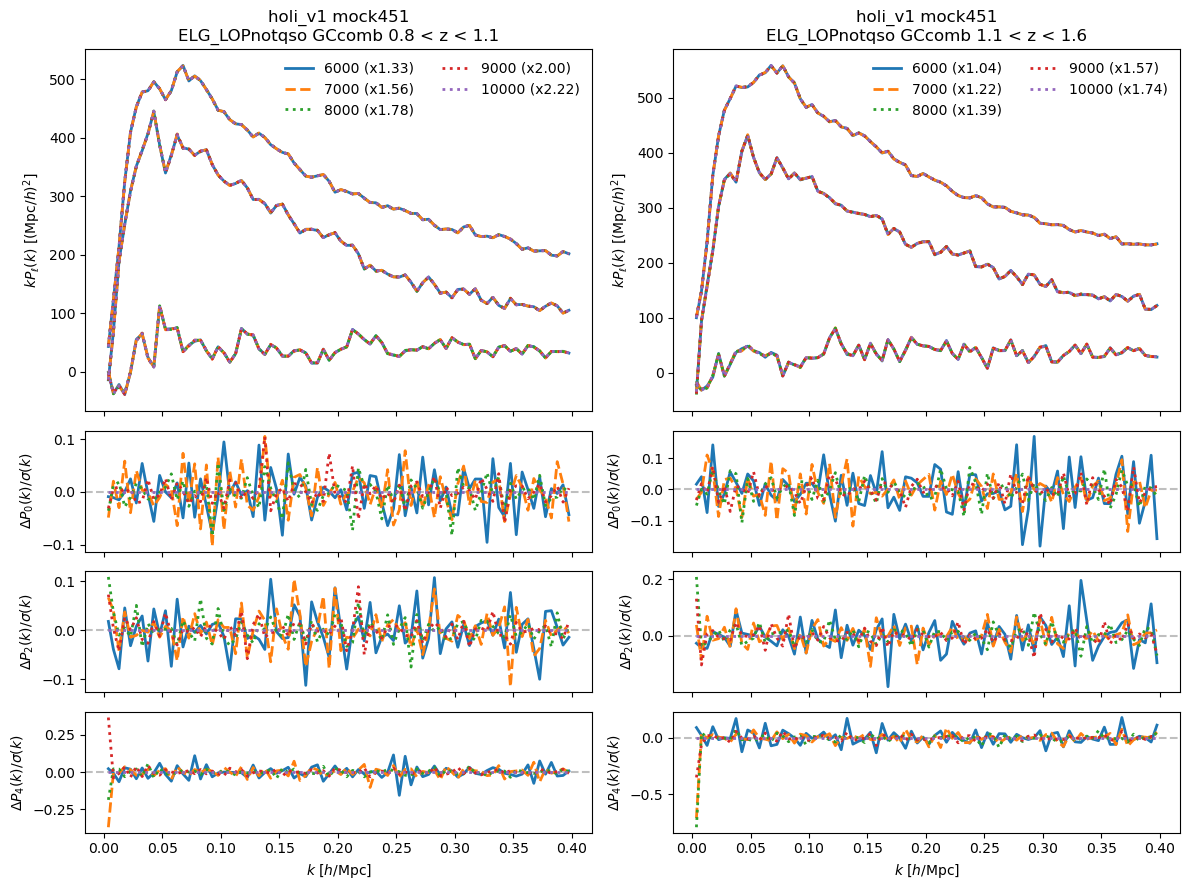

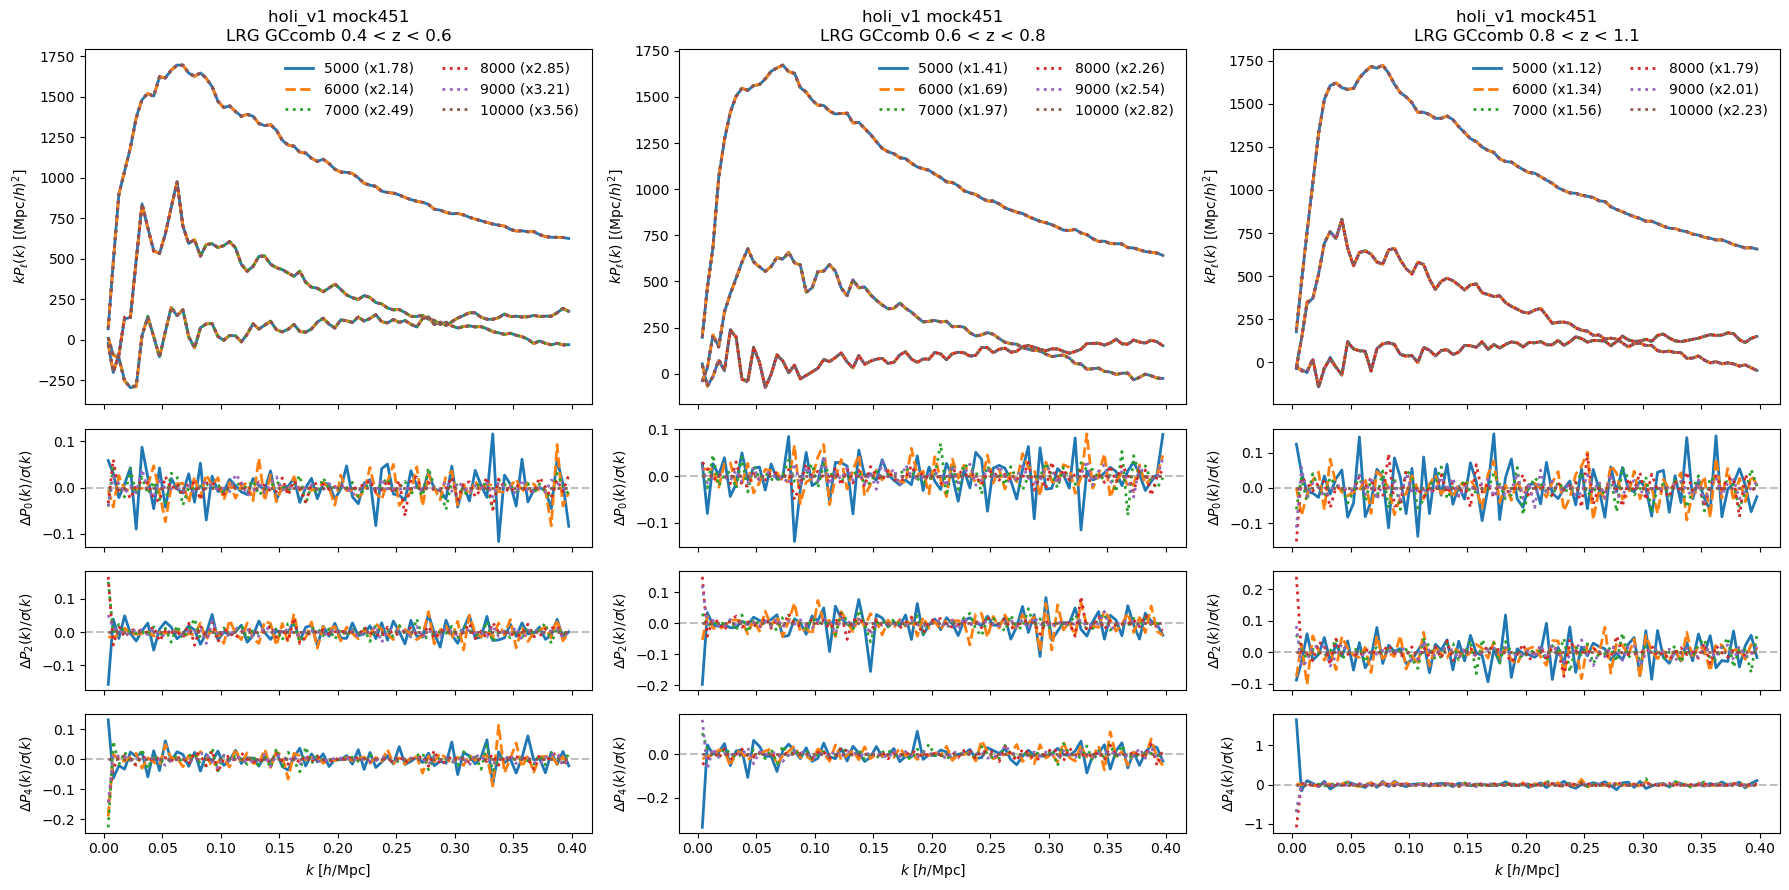

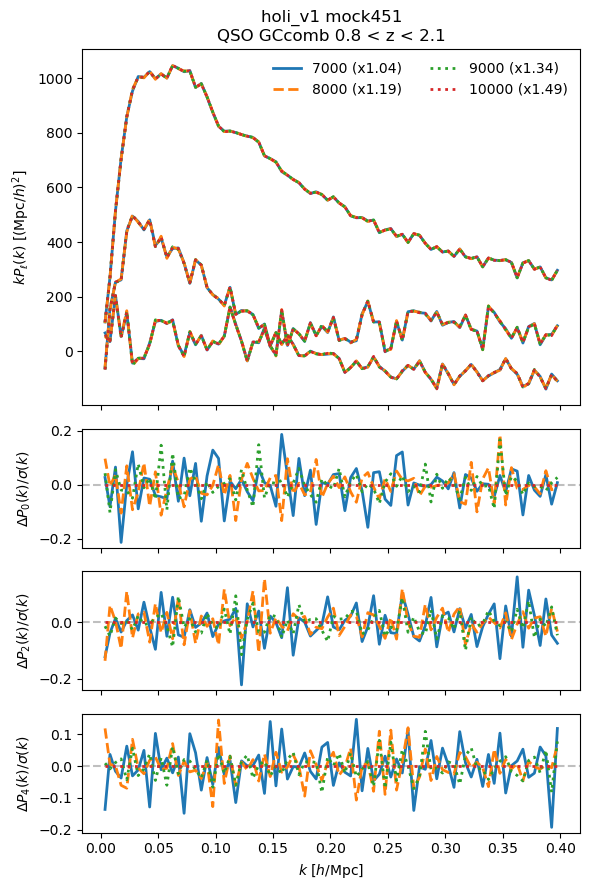

100%|██████████| 1/1 [00:13<00:00, 13.61s/it]


In [14]:
mock_version = "holi_v1"
pk4cov_dir = "/pscratch/sd/a/arosado/cai-dr2-benchmarks/randoms_checks/"
base_dir   = "/pscratch/sd/a/arosado/cai-dr2-benchmarks/boxsize_checks/"
cai_dir    = "/global/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/holi_v1/"

tracer = 'ELG_LOPnotqso'
weight_type = weight_type2 = 'default_FKP'
regions = labels = ['GCcomb'] #code below only works for GCcomb
ls = ['-','--',':',':',':',':']
tracers = ['ELG_LOPnotqso','LRG','QSO']
mocks_list = [451]
ells = [0,2,4]
lw = 2

for mocki in tqdm(mocks_list):
    pk_dir = base_dir + f"/mock{mocki}/"
    output_fn_args = dict(base_dir=pk_dir, kind='mesh2_spectrum_poles', file_type='h5')
    for tracer in tracers:
        data_fn  = [cai_dir + f"/altmtl{mocki}/loa-v1/mock{mocki}/LSScats/{tracer}_{reg}_clustering.dat.h5" for reg in ['NGC','SGC']] 
        data_full = Catalog.read(data_fn[0],group='LSS')
        data_full.append(Catalog.read(data_fn[1],group='LSS'))
        
        z_bins = zrange_dict[tracer]
        ncols = len(z_bins)

        height_ratios = [max(len(ells), 3)] + [1] * len(ells)
        figsize = (6 * ncols, 1.5 * sum(height_ratios))

        fig, lax = plt.subplots(len(height_ratios), ncols,sharex='col',gridspec_kw={'height_ratios': height_ratios},
                                figsize=figsize,squeeze=False)
        fig.subplots_adjust(hspace=0.1, wspace=0.15)
        boxsize_list = boxsize_list_dict[tracer]
        for iz, (zmin, zmax) in enumerate(z_bins):
            mask = (data_full['Z'] >= zmin) & ( data_full['Z'] <= zmax)
            data = data_full[mask]
            min_boxsize = get_min_boxsize(data)
            
            stats = {str(ibox): {} for ibox in boxsize_list}
            
            # get dispersion from mocks
            mocks4cov_list = [i for i in range(451,461)]
            fns = [pk4cov_dir + f"mock{mocki}/mesh2_spectrum_poles_{tracer}_GCcomb_z{zmin}-{zmax}_default_FKP_nran18_cellsize7.8_boxsize10000.h5" for mocki in mocks4cov_list] 
            pks = [read(fn).select(k=slice(0, None, 5)) for fn in fns]
            std_dict = {str(ell): np.std([pks[i].get(ell).value().real for i in range(len(mocks4cov_list))],axis=0) for ell in ells}
            
            for icolor, boxsize in enumerate(boxsize_list):
                for region in regions:
                    fn = get_power_fn(**output_fn_args, tracer=tracer, region=region, zmin=zmin, zmax=zmax, weight_type=weight_type, weight_type2=weight_type2,
                                      nran=nran, boxsize=boxsize, cellsize=cellsize_dict[tracer])
                    ref = read(fn).select(k=slice(0, None, 5))
                    ax = lax[0, iz]
                    ax.set_title(f'{mock_version} mock{mocki}\n{tracer} {region} {zmin:.1f} < z < {zmax:.1f}')
                    ax.set_ylabel(rf'$k P_\ell(k)$ [$(\mathrm{{Mpc}}/h)^2$]')
                    for ill, ell in enumerate(ells):
                        pole = ref.get(ell)
                        value = pole.value().real
                        ax.plot(pole.coords('k'), pole.coords('k') * value, linestyle=ls[icolor], color=f"C{icolor}",lw=lw)
                        stats[str(boxsize)][str(ell)] = value

            for icolor, boxsize in enumerate(boxsize_list):
                ax.plot([], [],linestyle=ls[icolor],color=f"C{icolor}",lw=lw,label=f"{boxsize} (x{boxsize/np.max(min_boxsize):.2f})")
            # if iz == 0:
            ax.legend(frameon=False, ncol=2)

            for ill, ell in enumerate(ells):
                ax = lax[ill + 1, iz]
                ax.axhline(0, color='grey', linestyle='--', alpha=0.5)
                ax.set_ylabel(rf'$\Delta P_{ell}(k)/\sigma(k)$')
                
                value_bench = stats['10000'][str(ell)]

                for icolor, boxsize in enumerate(boxsize_list):
                    value = stats[str(boxsize)][str(ell)]
                    ax.plot(pole.coords('k'), (value_bench-value)/std_dict[str(ell)], linestyle=ls[icolor], color=f"C{icolor}",lw=lw)
                    
            lax[-1, iz].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')

        plt.tight_layout()
        fig.savefig(f'plots_tests/test_boxsizes_{tracer}.png', bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()
